# Melbourne Airbnb Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

pd.options.display.max_rows=2000
pd.options.display.max_columns=500

In [2]:
data = pd.read_csv('melbourne_listings.csv',low_memory=False)
data.shape

(25741, 106)

In [3]:
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,20200215012707,2020-02-15,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",none,Very safe! Family oriented. Older age group.,NaN,"YES ! The bus (305,309) is exactly two blocks ...","Kitchen, backyard, upstairs lounge. We'd like ...",As much as the guest wants.,Prefence would be given females or a couple,NaN,NaN,https://a0.muscache.com/im/pictures/44620/5a58...,NaN,33057,https://www.airbnb.com/users/show/33057,Manju,2009-08-21,AU,About us: We are an East Indian couple in our ...,a few days or more,0%,0%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",f,f,"Bulleen, VIC, Australia",Balwyn North,Manningham,NaN,Bulleen,VIC,3105,Melbourne,"Bulleen, Australia",AU,Australia,-37.77268,145.09213,f,House,Private room,2,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Do...",NaN,$60.00,NaN,NaN,NaN,NaN,1,$22.00,1,365,1,1,365,365,1.0,365.0,31 months ago,t,30,60,90,365,2020-02-15,4,0,2011-05-24,2015-09-12,90.0,9.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.04
1,10803,https://www.airbnb.com/rooms/10803,20200215012707,2020-02-15,Room in Cool Deco Apartment in Brunswick East,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,none,This hip area is a crossroads between two grea...,Due to Airbnb policies I don’t accept bookings...,Easy transport options - the tram is right out...,Wifi. Bathroom and kitchen is shared but I mos...,I'm home mostly but sometimes I may be working...,Theres a yoga studio downstairs so if you see ...,NaN,NaN,https://a0.muscache.com/im/pictures/31323790/9...,NaN,38901,https://www.airbnb.com/users/show/38901,Lindsay,2009-09-16,"Melbourne, Victoria, Australia",As an artist working in animation and video I ...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/38901/profile...,https://a0.muscache.com/im/users/38901/profile...,Brunswick,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Brunswick East, VIC, Australia",Brunswick,More

In [4]:
def clean_price(price_series):
     return pd.to_numeric(price_series.str.replace("$","").str.replace(",",""))

def bin_price(price_series_cleaned):
    
    bins = [0,100,200,300,400,50000]

    labels = ['$1-99',
            '$100-199',
            '$200-299',
            '$300-399',
            'More than $400']
    
    return pd.cut(price_series_cleaned, bins, labels=labels)


def is_cbd(neighbourhood_cleansed_series, city):
    return neighbourhood_cleansed_series.apply(lambda row: 1 if row == city else 0)


def area(is_cbd_series, city):
    return is_cbd_series.map({0: 'Suburbs', 1: 'City Area'})


def clean_property(property_df, property_feature):

    apartment_property = property_df[property_feature].isin(['Apartment','Condominium'])
    property_df.loc[apartment_property,property_feature] = 'Apartment'
    
    house_property = property_df[property_feature].isin(['House','Townhouse','Cottage','Villa'])
    property_df.loc[house_property,property_feature] = 'House/Townhouse'
    
    other_property = ~property_df[property_df[property_feature].notnull()][property_feature].isin(['Apartment','House/Townhouse'])
    property_df.loc[other_property,property_feature] = 'Others'

In [5]:
df = data.copy()

df['price'] = clean_price(df['price'])
df['price_range'] = bin_price(df['price'])
df['is_cbd'] = is_cbd(df['neighbourhood_cleansed'], 'Melbourne')
df['area'] = area(df['is_cbd'], 'Melbourne')
df['state_city'] = 'Melbourne'

cbd = df[df['is_cbd'] == 1]
not_cbd = df[df['is_cbd'] == 0]

clean_property(df,'property_type')

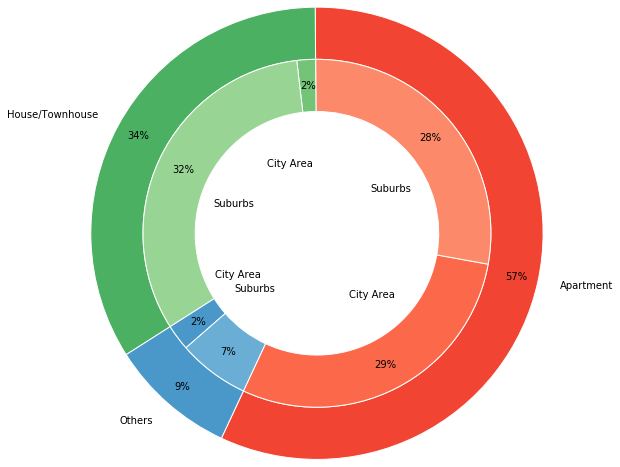

In [6]:
# outer circle
outer_label = ['Apartment','House/Townhouse','Others']
outer = df['property_type'].value_counts(normalize=True).values

# inner circle
inner_label = ['City Area','Suburbs','City Area','Suburbs','City Area','Suburbs']
inner = df.groupby(['property_type'])['area'].value_counts(normalize=True).sort_index()

inner = [outer[0]*inner[0],
         outer[0]*inner[1],
         outer[1]*inner[2],
         outer[1]*inner[3],
         outer[2]*inner[4],
         outer[2]*inner[5]]

size=0.3
a, b, c=[plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]

fig, ax = plt.subplots(figsize=[10,8])
ax.axis('equal')
ax.pie(outer, radius=1.3, labels=outer_label,wedgeprops=dict(width=size, edgecolor='w'),colors= [a(0.6), b(0.6), c(0.6)],startangle=-115,autopct='%.f%%',pctdistance=0.9)
ax.pie(inner, radius=1.3-0.3, labels=inner_label,labeldistance=0.4, wedgeprops=dict(width=size, edgecolor='w'), colors=[a(0.5), a(0.4), b(0.5), b(0.4), c(0.6), c(0.5)],startangle=-115,autopct='%.f%%',pctdistance=0.85);

plt.savefig('1.png')

## Part I: Are airbnb listings more expensive in city area than suburbs?

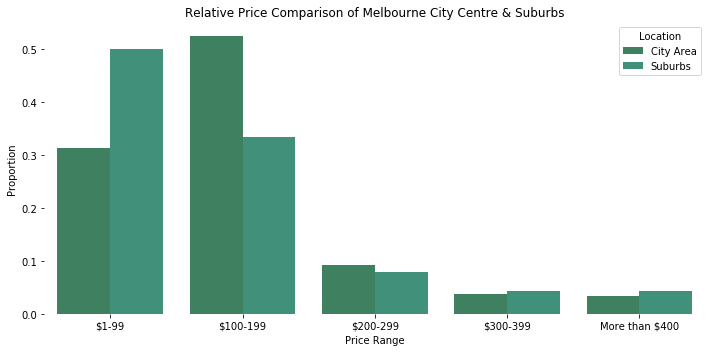

In [7]:
sub = df.groupby('area')['price_range'].value_counts(normalize=True).rename('val').sort_index().reset_index()

plt.figure(figsize=[10,5])
sns.barplot(data=sub,x='price_range',y='val',hue='area',palette='viridis_d')
sns.despine(left=True, bottom=True, right=True)
plt.xlabel('Price Range')
plt.ylabel('Proportion')
plt.title('Relative Price Comparison of Melbourne City Centre & Suburbs')
plt.legend(title='Location')
#plt.yticks([])

plt.tight_layout()
plt.savefig('2.png');

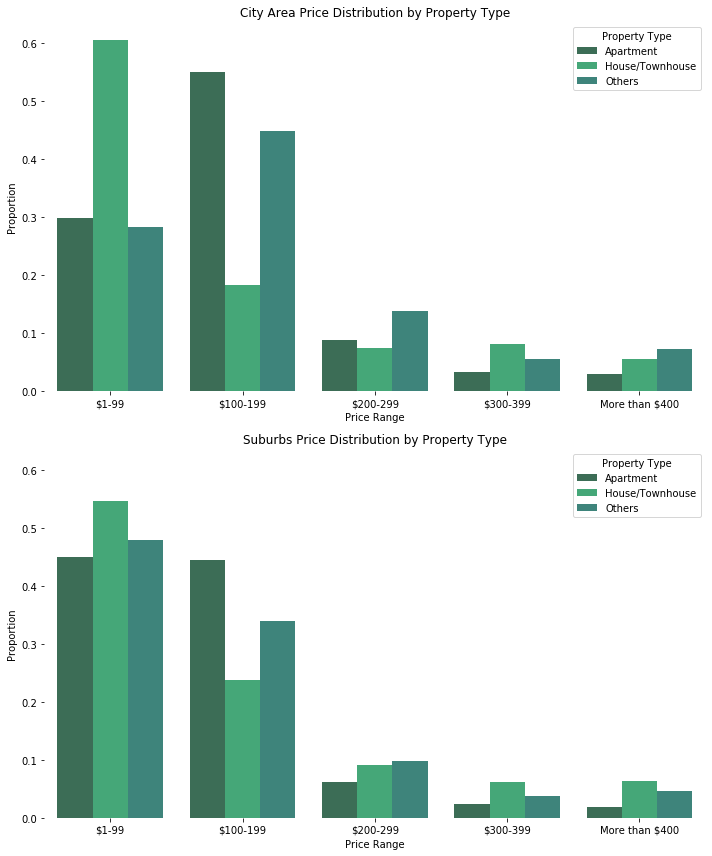

In [8]:
agg = df.groupby(['area','property_type'])['price_range'].value_counts(normalize=True).sort_index().rename('prop').reset_index()
city_agg = agg[agg['area'] == 'City Area']
suburb_agg = agg[agg['area'] == 'Suburbs']

agg_df = [city_agg,suburb_agg]
agg_title = ['City Area Price Distribution by Property Type','Suburbs Price Distribution by Property Type']

fig, ax = plt.subplots(2,1,figsize=[10,12],sharey=True)

for i, df_agg in enumerate(agg_df):
     
    axes=ax[i]
    sns.barplot(data=df_agg,x='price_range',y='prop',hue='property_type',palette='viridis_d',ax=axes)
    sns.despine(left=True, bottom=True, right=True)
    
    axes.set_xlabel('Price Range')
    axes.title.set_text(agg_title[i])
    axes.set_ylabel('Proportion')
    axes.legend().set_title('Property Type')
    
plt.tight_layout()    
plt.savefig('3.png')

In [9]:
city_area = df[(df['neighbourhood_cleansed'] == 'Melbourne')]
suburbs = df[(df['neighbourhood_cleansed'] != 'Melbourne')]

In [10]:
city_apt = city_area[city_area['property_type'] == 'Apartment']['neighbourhood'].value_counts(normalize=True).reset_index(name='apt_proportion')
city_house = city_area[city_area['property_type'] == 'House/Townhouse']['neighbourhood'].value_counts(normalize=True).reset_index(name='hse_proportion')
city_prop = pd.merge(city_apt,city_house,on='index')

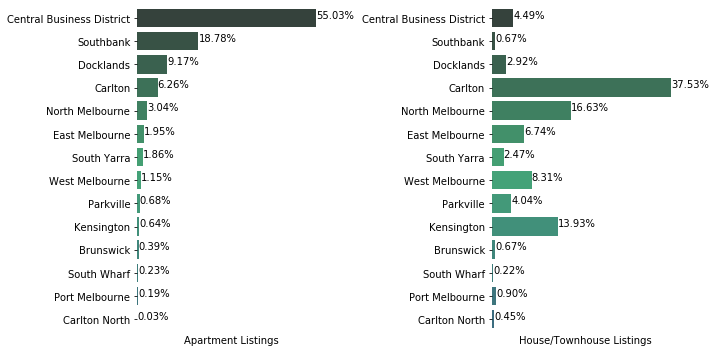

In [11]:
prop_type = ['apt_proportion','hse_proportion']
prop_lbl = ['Apartment Listings', 'House/Townhouse Listings']

fig, ax = plt.subplots(1,2,figsize=[10,5])

for i, var in enumerate(prop_type):

    axes = ax[i]

    y=city_prop.iloc[:,0]
    x=city_prop[var]


    sns.barplot(x,y,ax=axes,palette='viridis_d')
    sns.despine(left=True, bottom=True, right=True)
    axes.set_ylabel('')
    axes.set_xticks([])
    axes.set_xlabel(prop_lbl[i])
    
    for idx in range(city_prop.shape[0]):
        val = x.iloc[idx]
        pct = '{:.2f}%'.format(val * 100)
        axes.text(val,idx,pct)

plt.tight_layout()
plt.savefig('4.png')

## Part II: What are the general characteristics of being a superhost?

In [12]:
df['host_is_superhost'] = df['host_is_superhost'].map({'f':0,'t':1})

superhost = df[df['host_is_superhost'] == 1 ]
not_superhost = df[df['host_is_superhost'] == 0 ]

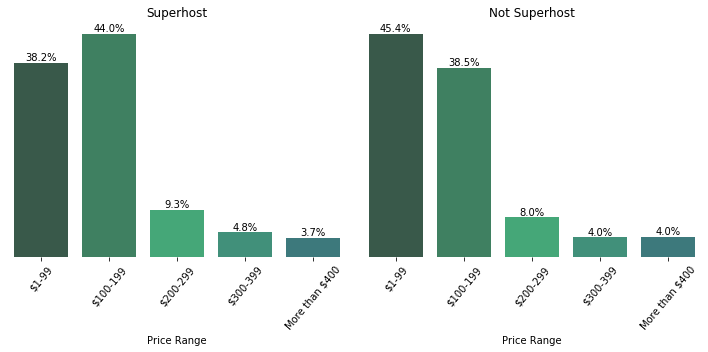

In [13]:
superhost_df = [superhost,not_superhost]
title = ['Superhost','Not Superhost']

fig, ax = plt.subplots(1,2,figsize=[10,5])

for i, df in enumerate(superhost_df):
    
    axes = ax[i]
    val_count = df['price_range'].value_counts(normalize=True).sort_index()
    x = val_count.index
    y = val_count.values
    
    sns.barplot(x,y,ax=axes, palette='viridis_d')
    sns.despine(left=True, bottom=True, right=True)
    axes.set_xticklabels(axes.get_xticklabels(),rotation=50)
    axes.set_title(title[i])
    axes.set_xlabel('Price Range')
    axes.set_yticklabels('')
    axes.set_yticks([])
    
    for i, val in enumerate(y):
        pct = '{:.1f}%'.format( val * 100)
        axes.text(i,val+0.005,pct,ha='center')
    
plt.tight_layout()  
plt.savefig('5.png')

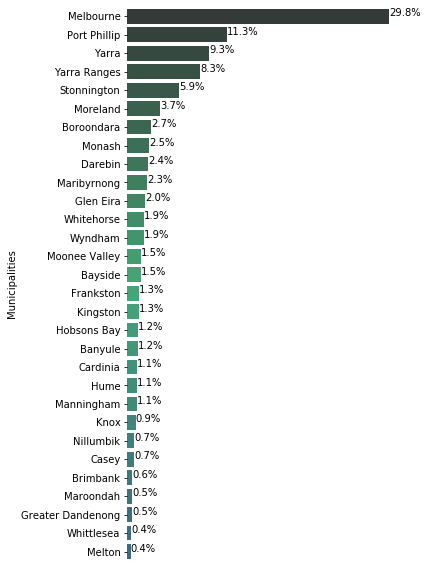

In [14]:
sh_mcp = superhost['neighbourhood_cleansed'].value_counts(normalize=True)

x = sh_mcp.values
y = sh_mcp.index

plt.figure(figsize=[6,8])
sns.barplot(x,y,palette='viridis_d')
sns.despine(left=True, bottom=True, right=True)
plt.ylabel('Municipalities')
#plt.title('Pct of superho')
plt.xticks([])

for i, val in enumerate(x):
    pct = '{:.1f}%'.format(val * 100)
    plt.text(val,i,pct)

plt.tight_layout()
plt.savefig('6.png')

### superhosts in city area

In [15]:
city_superhost = superhost[superhost['neighbourhood_cleansed'] == 'Melbourne']
not_city_superhost = superhost[superhost['neighbourhood_cleansed'] != 'Melbourne']

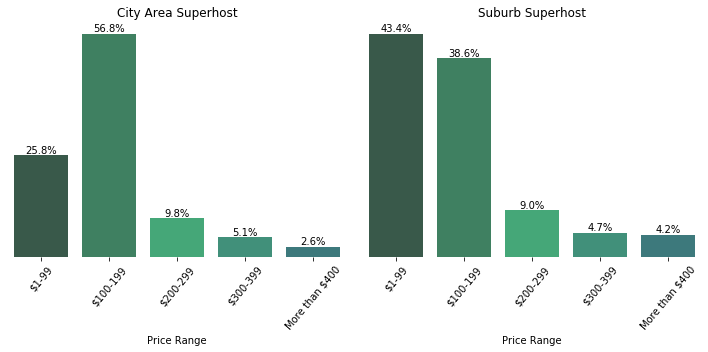

In [16]:
superhost_area = [city_superhost,not_city_superhost]
title = ['City Area Superhost','Suburb Superhost']

fig, ax = plt.subplots(1,2,figsize=[10,5])

for i, df in enumerate(superhost_area):
    
    val_count = df['price_range'].value_counts(normalize=True).sort_index()
    x = val_count.index
    y = val_count.values
    
    axes = ax[i]
    sns.barplot(x,y,ax=axes, palette='viridis_d')
    sns.despine(left=True, bottom=True, right=True)
    axes.set_xticklabels(ax[i].get_xticklabels(),rotation=50)
    axes.set_title(title[i])
    axes.set_xlabel('Price Range')
    axes.set_ylabel('')
    axes.set_yticks([])
    
    for i, val in enumerate(y):
        pct = '{:.1f}%'.format(val * 100)
        axes.text(i,val+0.005,pct,ha='center')    
    
plt.tight_layout()  
plt.savefig('7.png')

In [17]:
superhost_prop  = superhost[superhost['neighbourhood_cleansed'] == 'Melbourne']['price_range'].value_counts(normalize=True).sort_index().reset_index(name='sh')
not_superhost_prop = not_superhost[not_superhost['neighbourhood_cleansed'] == 'Melbourne']['price_range'].value_counts(normalize=True).sort_index().reset_index(name='not_sh')

sh_group = pd.merge(superhost_prop,not_superhost_prop,on='index')
sh_group['diff'] = sh_group['sh'] - sh_group['not_sh']
sh_group

,index,sh,not_sh,diff
0,$1-99,0.257610,0.327434,-0.069824
1,$100-199,0.567644,0.512832,0.054812
2,$200-299,0.098083,0.089823,0.008260
3,$300-399,0.050733,0.034218,0.016515
4,More than $400,0.025930,0.035693,-0.009763


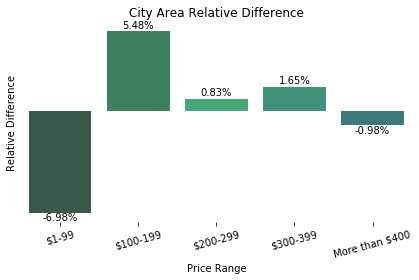

In [18]:
sns.barplot(x=sh_group['index'],y=sh_group['diff'],palette='viridis_d')
sns.despine(left=True, bottom=True, right=True)

plt.xticks(rotation=15)
plt.title('City Area Relative Difference')
plt.yticks([])
plt.xlabel('Price Range')
plt.ylabel('Relative Difference')

for i in range(sh_group.shape[1]+1):

    val = sh_group['diff'].iloc[i]
    pct_val = val*100
    pct_str = '{:.2f}%'.format(pct_val)

    if pct_val > 0:
        plt.text(i,val+0.0025,pct_str,ha='center')

    else:
        plt.text(i,val-0.0055,pct_str,ha='center')
     
plt.tight_layout()
plt.savefig('8.png');

In [19]:
superhost_prop  = superhost[superhost['neighbourhood_cleansed'] != 'Melbourne']['price_range'].value_counts(normalize=True).sort_index().reset_index(name='sh')
not_superhost_prop = not_superhost[not_superhost['neighbourhood_cleansed'] != 'Melbourne']['price_range'].value_counts(normalize=True).sort_index().reset_index(name='not_sh')

sh_group = pd.merge(superhost_prop,not_superhost_prop,on='index')
sh_group['diff'] = sh_group['sh'] - sh_group['not_sh']
sh_group

,index,sh,not_sh,diff
0,$1-99,0.434460,0.520652,-0.086193
1,$100-199,0.386053,0.318360,0.067693
2,$200-299,0.090343,0.075533,0.014810
3,$300-399,0.046969,0.042458,0.004510
4,More than $400,0.042176,0.042997,-0.000821


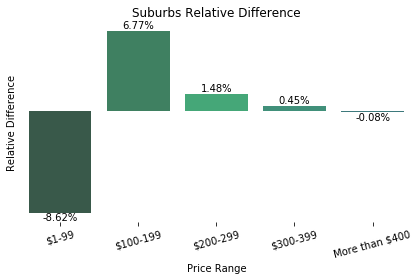

In [20]:
sns.barplot(x=sh_group['index'],y=sh_group['diff'],palette='viridis_d')
sns.despine(left=True, bottom=True, right=True)
plt.xticks(rotation=15)
plt.title('Suburbs Relative Difference')
plt.yticks([])
plt.xlabel('Price Range')
plt.ylabel('Relative Difference')

for i in range(sh_group.shape[1]+1):

    val = sh_group['diff'].iloc[i]
    pct_val = val*100
    pct_str = '{:.2f}%'.format(pct_val)

    if pct_val > 0:
        plt.text(i,val+0.0025,pct_str,ha='center')

    else:
        plt.text(i,val-0.0065,pct_str,ha='center')

plt.tight_layout()
plt.savefig('9.png');

## Part III: Which features contribute more to price?

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [22]:
df = data.copy()
df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,20200215012707,2020-02-15,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",none,Very safe! Family oriented. Older age group.,NaN,"YES ! The bus (305,309) is exactly two blocks ...","Kitchen, backyard, upstairs lounge. We'd like ...",As much as the guest wants.,Prefence would be given females or a couple,NaN,NaN,https://a0.muscache.com/im/pictures/44620/5a58...,NaN,33057,https://www.airbnb.com/users/show/33057,Manju,2009-08-21,AU,About us: We are an East Indian couple in our ...,a few days or more,0%,0%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",f,f,"Bulleen, VIC, Australia",Balwyn North,Manningham,NaN,Bulleen,VIC,3105,Melbourne,"Bulleen, Australia",AU,Australia,-37.77268,145.09213,f,House,Private room,2,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,""Pets live on this property"",Do...",NaN,$60.00,NaN,NaN,NaN,NaN,1,$22.00,1,365,1,1,365,365,1.0,365.0,31 months ago,t,30,60,90,365,2020-02-15,4,0,2011-05-24,2015-09-12,90.0,9.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.04


In [23]:
df['price'] = clean_price(df['price'])
df['price_range'] = bin_price(df['price'])
df['is_city_area'] = is_cbd(df['neighbourhood_cleansed'], 'Melbourne')

In [24]:
corr_df = df.corr()['price'].sort_values(ascending=False)
corr_df.reset_index(name='corr')

,index,corr
0,price,1.000000e+00
1,bedrooms,2.668249e-01
2,accommodates,2.630921e-01
3,square_feet,2.345251e-01
4,beds,2.333343e-01
5,bathrooms,2.262355e-01
6,guests_included,1.573500e-01
7,availability_365,1.007408e-01
8,host_listings_count,9.985964e-02
9,host_total_listings_count,9.985964e-02


In [25]:
attr = corr_df[corr_df.values > abs(0.1)].index
attribs = list(attr)

In [26]:
melb_df = df[attribs]
melb_df.isnull().sum() / melb_df.shape[0]

price               0.000000
bedrooms            0.001243
accommodates        0.000000
square_feet         0.993046
beds                0.007342
bathrooms           0.000738
guests_included     0.000000
availability_365    0.000000
dtype: float64

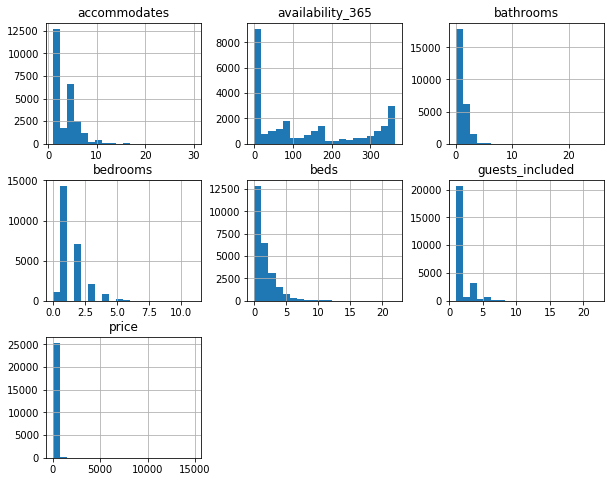

In [27]:
melb_df = melb_df.drop('square_feet',axis=1)
attribs.remove('square_feet')

melb_df.hist(figsize=[10,8],bins=20);

In [28]:
melb_df.describe()

,price,bedrooms,accommodates,beds,bathrooms,guests_included,availability_365
count,25741.000000,25709.000000,25741.000000,25552.000000,25722.000000,25741.000000,25741.000000
mean,159.563848,1.558287,3.513111,1.986772,1.324217,1.889592,132.802300
std,307.575808,0.974147,2.336551,1.546426,0.639442,1.518089,135.895932
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,70.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000
50%,116.000000,1.000000,3.000000,1.000000,1.000000,1.000000,84.000000
75%,171.000000,2.000000,4.000000,2.000000,1.500000,2.000000,270.000000
max,14885.000000,11.000000,30.000000,22.000000,25.000000,22.000000,365.000000


In [29]:
# drop rows with price less than 10 
melb_df.drop(melb_df[melb_df['price'] < 10].index,inplace=True)

In [30]:
# filling missing values with median
imputer = SimpleImputer(strategy='median')
imputer.fit(melb_df)

melb = imputer.transform(melb_df)
melb = pd.DataFrame(melb,columns=melb_df.columns)

In [31]:
melb

,price,bedrooms,accommodates,beds,bathrooms,guests_included,availability_365
0,60.0,1.0,2.0,2.0,1.0,1.0,365.0
1,36.0,1.0,2.0,2.0,1.0,1.0,214.0
2,159.0,1.0,2.0,1.0,1.0,2.0,71.0
3,100.0,3.0,5.0,3.0,1.0,1.0,342.0
4,51.0,1.0,2.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...
25722,79.0,1.0,2.0,1.0,1.0,1.0,84.0
25723,27.0,1.0,1.0,1.0,1.0,1.0,15.0
25724,68.0,0.0,2.0,1.0,1.0,1.0,357.0
25725,112.0,1.0,1.0,1.0,1.0,1.0,83.0


In [32]:
X = melb.drop('price',axis=1)
y = melb['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Linear Regression

In [33]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

predictions = lin_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 91180.10413190004
rmse: 301.9604347127286
r2: 0.09728444649384327


### DT Regressor

In [34]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train,y_train)

predictions = dt_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 170034.72247773837
rmse: 412.3526676010941
r2: -0.6834044014110388


### Random Forest

In [35]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train,y_train)

predictions = rf_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 101234.45948059861
rmse: 318.1736310265177
r2: -0.0022572576987562876


### Gradient Boosting

In [36]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train,y_train)

predictions = gb_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 94644.96111447943
rmse: 307.6442118982241
r2: 0.06298112650284804


In [37]:
gb_reg.feature_importances_, X_train.columns

(array([0.24152878, 0.10971654, 0.17543772, 0.2164958 , 0.03951143,
        0.21730973]),
 Index(['bedrooms', 'accommodates', 'beds', 'bathrooms', 'guests_included',
        'availability_365'],
       dtype='object'))

## b) Price below 500

In [38]:
X = melb[melb['price'] < 500].drop('price',axis=1)
y = melb[melb['price'] < 500]['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Linear Regression

In [39]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

predictions = lin_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 4023.499454857218
rmse: 63.43106064742429
r2: 0.40490880838291754


### DT Regressor

In [40]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train,y_train)

predictions = dt_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 5337.642077503315
rmse: 73.05916833295679
r2: 0.2105420120059026


### Random Forest

In [41]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train,y_train)

predictions = rf_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 3882.860436314667
rmse: 62.312602548077436
r2: 0.42570986529155175


### Gradient Boosting

In [42]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train,y_train)

predictions = gb_reg.predict(X_test)

mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test,predictions)

print('mse: {}'.format(mse))
print('rmse: {}'.format(rmse))
print('r2: {}'.format(r_squared))

mse: 3442.0533477491304
rmse: 58.669015227367936
r2: 0.49090694523424827


In [43]:
gb_reg.feature_importances_, X_train.columns

(array([0.41458742, 0.41245106, 0.00626971, 0.06762991, 0.04875444,
        0.05030745]),
 Index(['bedrooms', 'accommodates', 'beds', 'bathrooms', 'guests_included',
        'availability_365'],
       dtype='object'))

In [44]:
feature_importance = pd.DataFrame({'Features':X_train.columns, 'Feature Importance':gb_reg.feature_importances_})
feature_importance.sort_values('Feature Importance',ascending=False,inplace=True)
feature_importance

,Features,Feature Importance
0,bedrooms,0.414587
1,accommodates,0.412451
3,bathrooms,0.067630
5,availability_365,0.050307
4,guests_included,0.048754
2,beds,0.006270


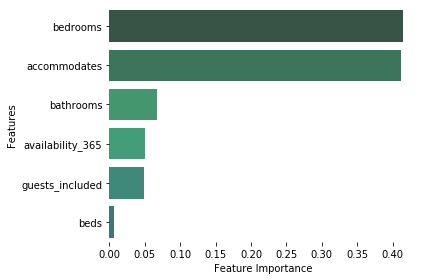

In [45]:
x = feature_importance.iloc[:,0]
y = feature_importance.iloc[:,1]

sns.barplot(y,x,palette='viridis_d')
sns.despine(left=True, bottom=True, right=True)

plt.tight_layout()
plt.savefig('10.png');